In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [160]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))
include(srcdirx("MinimalNetworks.jl"))

include(srcdirx("TrajectoryAnalysis.jl"))
include(srcdirx("ConvenienceFunctions.jl"))
include(srcdirx("Epistasis.jl"))
include(srcdirx("LearningFunctions.jl"))

include(srcdirx("GRNVisualization.jl"))
include(srcdirx("AnalysisVisualization.jl"))

exp_name = "RE_Minimal_Inhibiting_Main"

include(srcdirx("ExperimentSetups/Final_Experiments/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using DataFrames
using Combinatorics
using GraphMakie
using Graphs
using NetworkLayout
using LinearAlgebra
using UMAP


In [3]:
xgboost = pyimport("xgboost");

In [323]:
# color_scheme = cgrad(:tab20,categorical = true);

const color_scheme = Makie.wong_colors();

const node_colors = color_scheme[end-3:end];

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

color_name = ["purple","red","green","yellow","blue","pink"]

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

const weight_names_latex = [L"W_{aa}",L"W_{ab}",L"W_{ac}",L"W_{ba}",L"W_{bb}",L"W_{bc}",L"W_{ca}",L"W_{cb}",L"W_{cc}",L"W_{ma}"];


ErrorException: cannot declare weight_names_latex constant; it already has a value

In [5]:
data = load(datadirx("exp_pro/Final_Experiments/" * exp_name * "_RawData.jld2"));

In [6]:
plot_save_dir = "Final_Experiments/" * exp_name 

save_fig = false

false

In [256]:
seaborn_palette = palette(:seaborn_colorblind)

# seaborn_palette = palette(:Set3_9)

# top_n_colors = seaborn_palette[[1,4,5,9,10]]

# node_colors1 = seaborn_palette[[2,3,7,8]]


# top_n_colors = reverse(seaborn_palette[1:top_n]) |> collect

# node_colors1 = seaborn_palette[end-3:end]

top_n_colors = seaborn_palette[[1,2,3,5,end]]

node_colors1 = seaborn_palette[[8,7,4,9]];

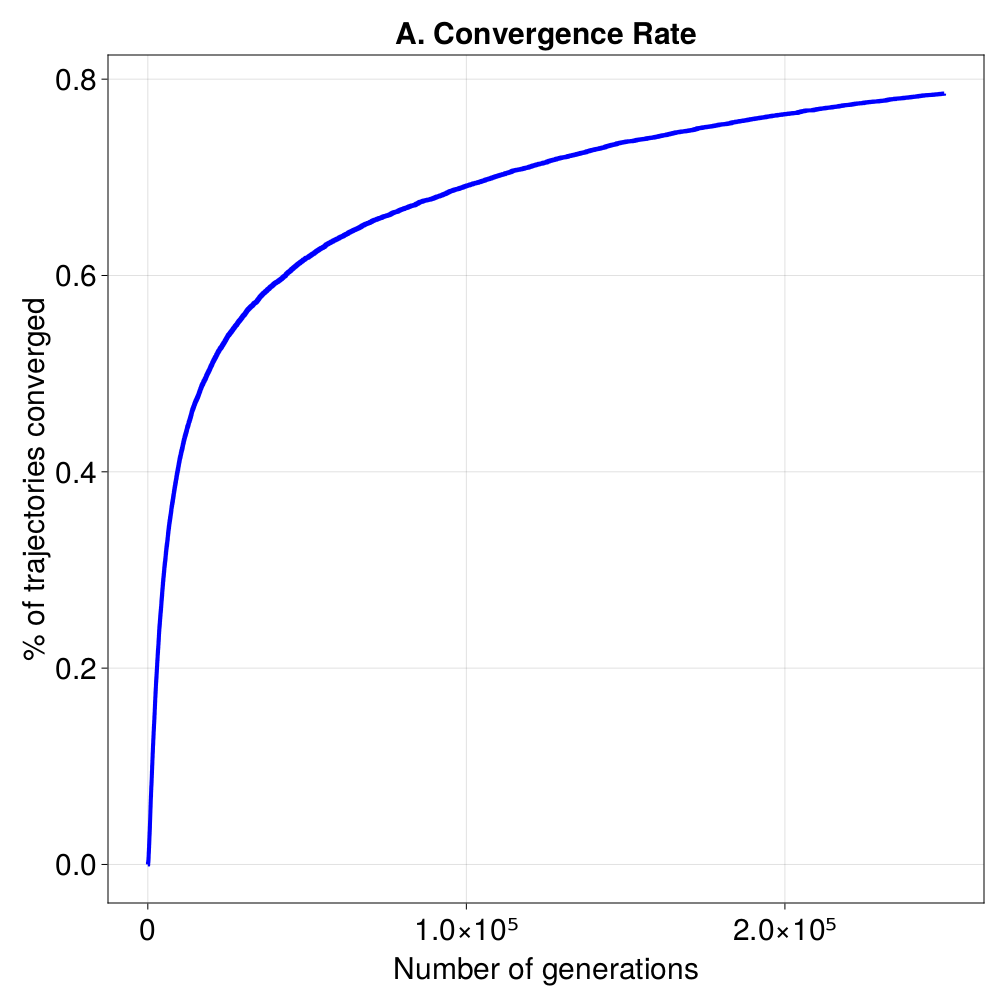

In [8]:
conv = copy(data["converged"]);

conv_time = map(x->sum(x),data["wait_times"])

nconv = sum(conv)

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1])

plot_convergence_rate!(ax,conv,conv_time,n_trials,max_gen)

cond_save(plotsdirx(plot_save_dir,"ConvergenceRate.png"),fig,save_fig)

fig

In [9]:
min_end_networks = data["min_end_networks"]
min_fs_networks = data["min_fs_networks"];

In [10]:
fs_mss =  map(list_mss->select_minimal_topologies(list_mss),min_fs_networks)
ls_mss =  map(list_mss->select_minimal_topologies(list_mss),min_end_networks);

In [11]:
countmap(map(x->length(x),min_end_networks))

Dict{Int64, Int64} with 3 entries:
  2 => 474
  3 => 22
  1 => 15211

In [12]:
trajectories = map(n->Trajectory(n,data["geno_traj"][conv][n],data["fitness_traj"][conv][n],data["wait_times"][conv][n],data["mut_type"][conv][n],weight_names),1:nconv);

for (n,tr) in enumerate(trajectories)
    assign_minimal_subgraphs!(tr,fs_mss[n],ls_mss[n])
end

inc_metagraph, vertex_top_map,top_vertex_map,vertex_complexity_map,inclusion_matrix = create_inclusion_metagraph(trajectories);

minimal_motif_id = findall(indegree(inc_metagraph) .== 0);

minimal_motifs = reduce(hcat,[vertex_top_map[vertex_id] for vertex_id in minimal_motif_id])

for tr in trajectories
    assign_inc_vertex_ids!(tr,top_vertex_map)
    assign_inc_parents!(tr,inclusion_matrix,vertex_complexity_map,minimal_motif_id)
end

In [13]:
end_parents = map(tr->tr.inc_metagraph_vertices[end],trajectories)

sorted_uep,sorted_counts_uep = return_order_by_count(end_parents);

uep_position_dict = Dict(v=>n for (n,v) in enumerate(sorted_uep));

top_n = 5

5

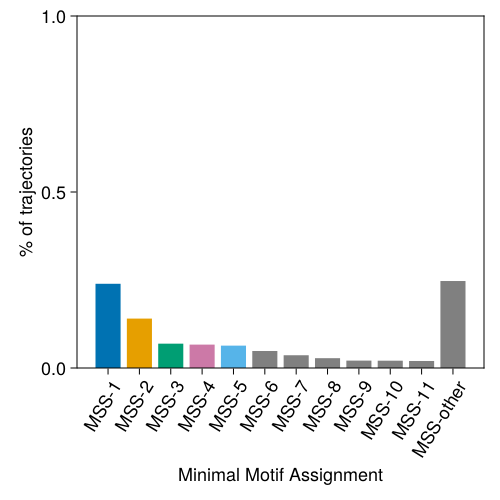

In [14]:
#####################

min_n = 200

fontsize = 18.

fig = CairoMakie.Figure(resolution = (500,500), fontsize = fontsize)

ax = Axis(fig[1,1], ylabel  = "% of trajectories", xlabel = "Minimal Motif Assignment")

plot_mst_distribution!(ax,sorted_counts_uep,top_n,min_n)

cond_save(plotsdirx(plot_save_dir,"MotifDistribution.png"),fig,save_fig)

fig

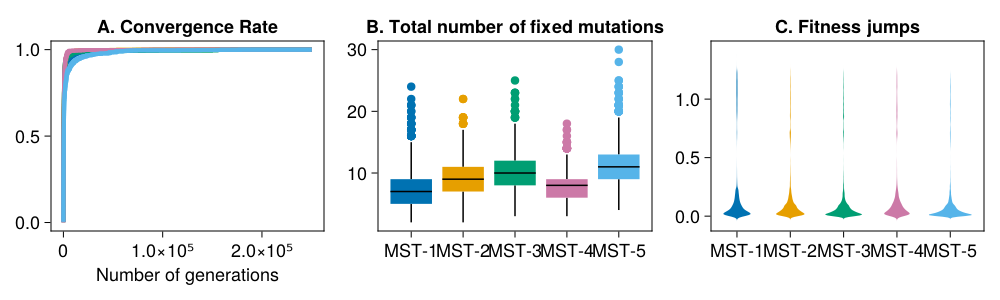

In [15]:
fig = CairoMakie.Figure(resolution = (1000,300), fontsize = 18.)

plot_minimal_evo_summary!(fig,trajectories,top_n,sorted_uep,uep_position_dict)

fig

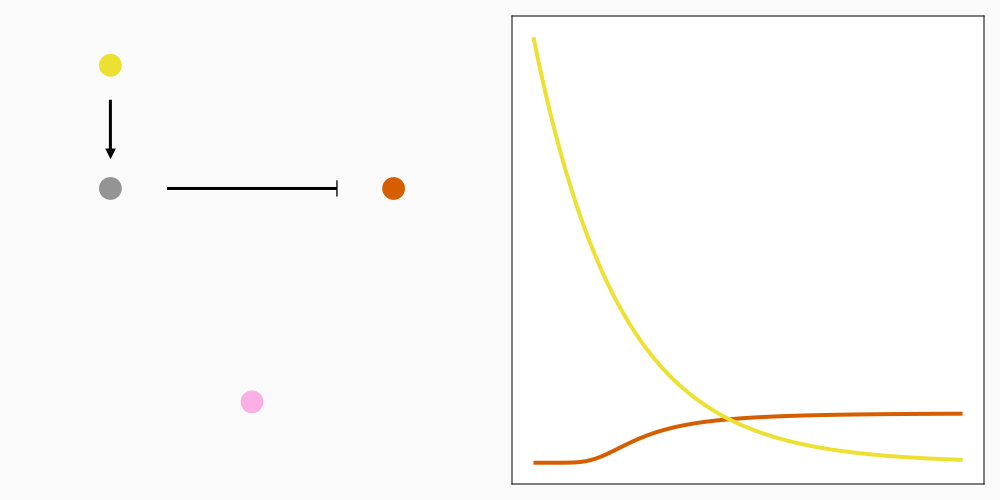

In [255]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = fontsize)

draw_config = fs18_default()

orig_network = trajectories[1].geno_traj[1]

draw_example_network!(fig,orig_network,["C","M"],draw_config,node_colors1,fontsize)

cond_save(plotsdirx(plot_save_dir,"Initial_network.png"),fig,save_fig)

fig

In [17]:
embedding = umap(data["dmat_av"], 2; metric = :precomputed,n_neighbors = 50,min_dist = 0.5);

In [18]:
trajectories_p_d = filter(tr->tr.inc_metagraph_vertices[end] ∈ sorted_uep[1:top_n],trajectories);

In [116]:
function fs18_default()

    fs = 18.

    l = fs / 10

    shift_factor_node =  0.85

    shift_factor_edge(x) = x ? 0.05*l : 0.

    shift_factor_label = 2*shift_factor_node

    arrow_size_act = 0.8*fs
    arrow_size_inh = 1.5*fs

    arrow_attr = (;linewidth = 3., color = :black)

    self_arc_radius = l/7

    node_size = 1.3*fs

    B_pos = Point2f((0.,0.))
    A_pos = Point2f((-l*cos(pi/3),l*sin(pi/3)))
    C_pos = Point2f((l*cos(pi/3),l*sin(pi/3)))

    M_pos = Point2f((A_pos[1],A_pos[2] + l/2))

    DrawGRNConfig(l,shift_factor_node,shift_factor_edge,shift_factor_label,arrow_size_act,arrow_size_inh,arrow_attr,self_arc_radius,node_size,A_pos,B_pos,C_pos,M_pos,[A_pos, B_pos, C_pos,M_pos],l/3,l/5)

end

draw_config_18 = fs18_default()

DrawGRNConfig(1.8, 0.85, var"#shift_factor_edge#4407"{Float64}(1.8), 1.7, 14.4, 27.0, (linewidth = 3.0, color = :black), 0.2571428571428572, 23.400000000000002, Float32[-0.9, 1.5588458], Float32[0.0, 0.0], Float32[0.9, 1.5588458], Float32[-0.9, 2.4588459], Point{2, Float32}[[-0.9, 1.5588458], [0.0, 0.0], [0.9, 1.5588458], [-0.9, 2.4588459]], 0.6, 0.36)

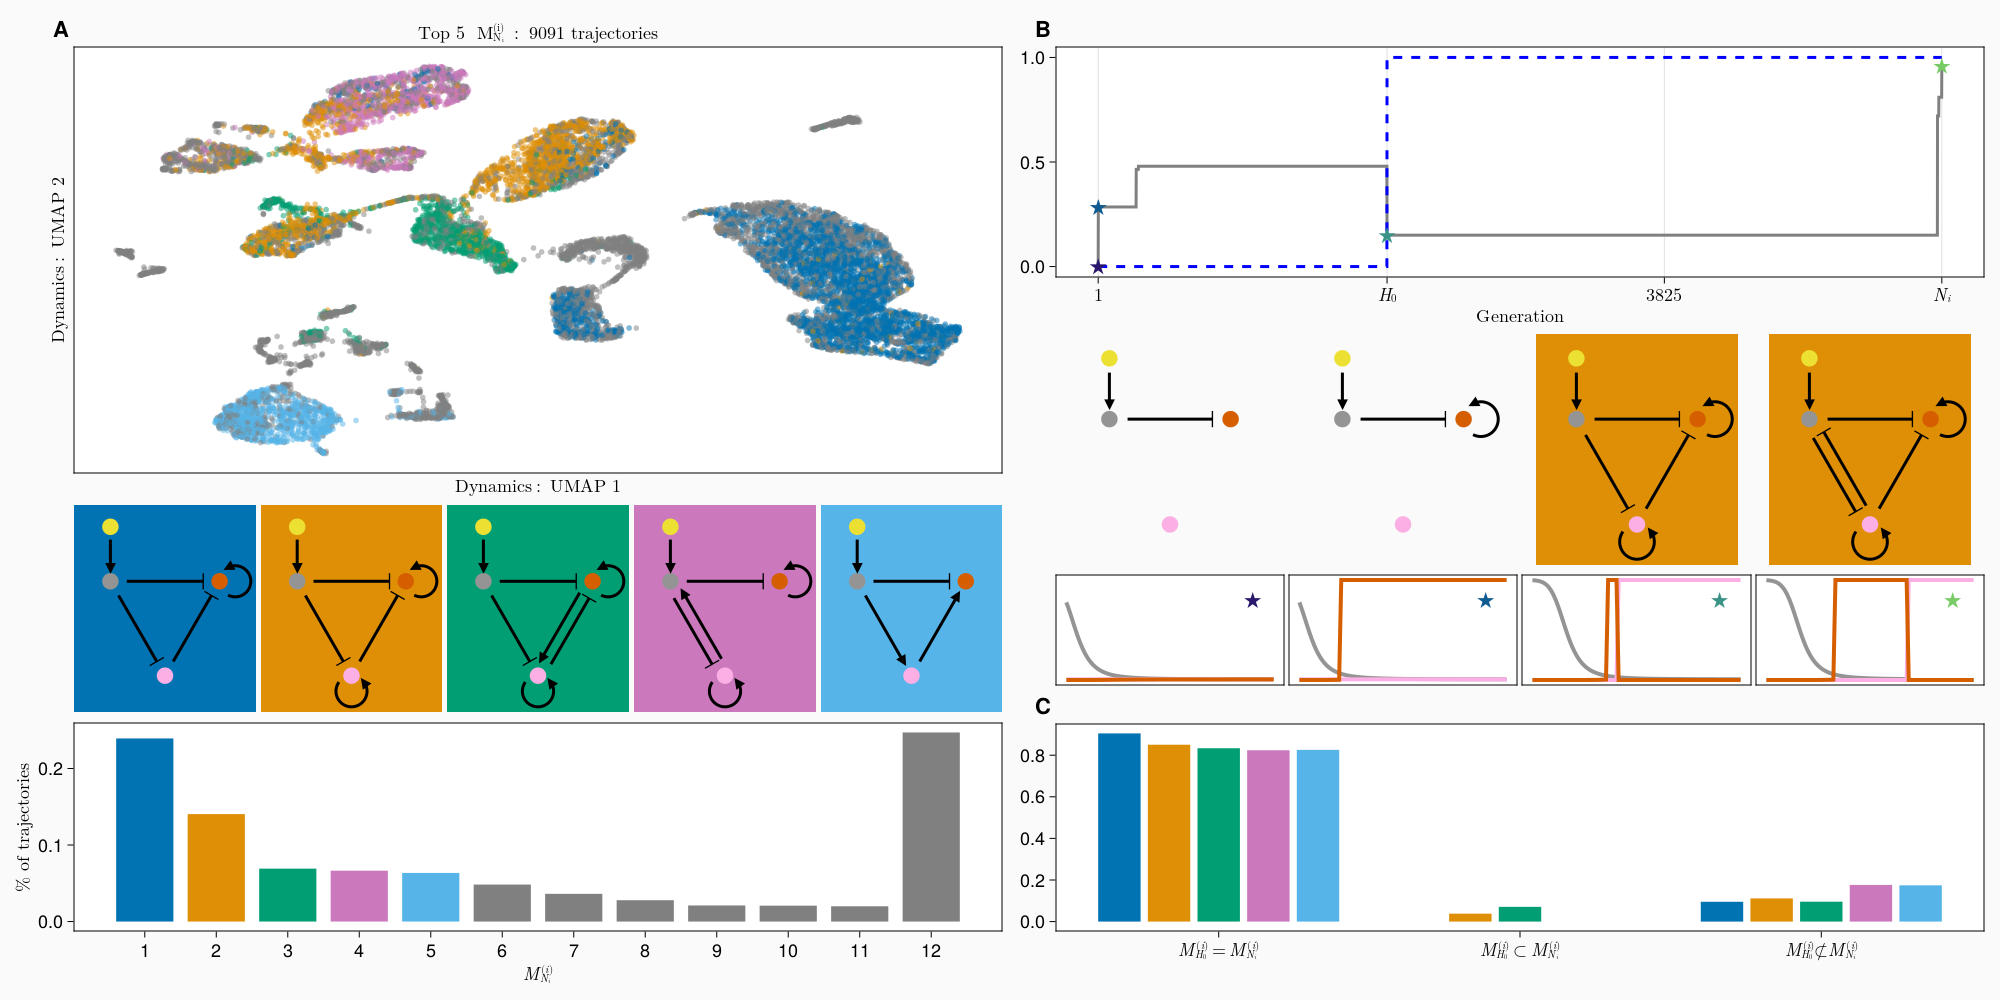

In [342]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (2000, 1000),fontsize = fontsize)

example_mst = 2

tr_choice = 12

# dynamical_summary_config(fontsize,embed_markersize,color_scheme,node_colors,draw_config,fitness_linewidth,fitness_markersize,pheno_linewidth,color_fade,caption_padding,caption_fontsize)

ds_config_18 = dynamical_summary_config(fontsize,8.,top_n_colors,node_colors1,draw_config_18,3.,22.,4.,20.,5,22)

plot_dynamical_summary!(fig,trajectories,embedding,top_n,min_n,sorted_uep,sorted_counts_uep,end_parents,vertex_top_map,example_mst,tr_choice,ds_config_18)

cond_save(plotsdirx(plot_save_dir,"DynamicalSummary.png"),fig,save_fig)

fig

In [179]:
function fs12_default()

    fs = 12.

    l = fs / 10

    # shift_factor_node =  l/(2.5)

    shift_factor_node = 0.8

    shift_factor_edge(x) = x ? 0.075*l : 0.

    shift_factor_label = 2*shift_factor_node

    arrow_size_act = 0.4*fs
    arrow_size_inh = 0.8*fs

    arrow_attr = (;linewidth = 1., color = :black)

    self_arc_radius = l/6

    node_size = 0.7*fs

    B_pos = Point2f((0.,0.))
    A_pos = Point2f((-l*cos(pi/3),l*sin(pi/3)))
    C_pos = Point2f((l*cos(pi/3),l*sin(pi/3)))

    M_pos = Point2f((A_pos[1],A_pos[2] + l/2))

    DrawGRNConfig(l,shift_factor_node,shift_factor_edge,shift_factor_label,arrow_size_act,arrow_size_inh,arrow_attr,self_arc_radius,node_size,A_pos,B_pos,C_pos,M_pos,[A_pos, B_pos, C_pos,M_pos],l/2,l/3)

end

draw_config_12 = fs12_default()

DrawGRNConfig(1.2, 0.8, var"#shift_factor_edge#13203"{Float64}(1.2), 1.6, 4.800000000000001, 9.600000000000001, (linewidth = 1.0, color = :black), 0.19999999999999998, 8.399999999999999, Float32[-0.6, 1.0392305], Float32[0.0, 0.0], Float32[0.6, 1.0392305], Float32[-0.6, 1.6392305], Point{2, Float32}[[-0.6, 1.0392305], [0.0, 0.0], [0.6, 1.0392305], [-0.6, 1.6392305]], 0.6, 0.39999999999999997)

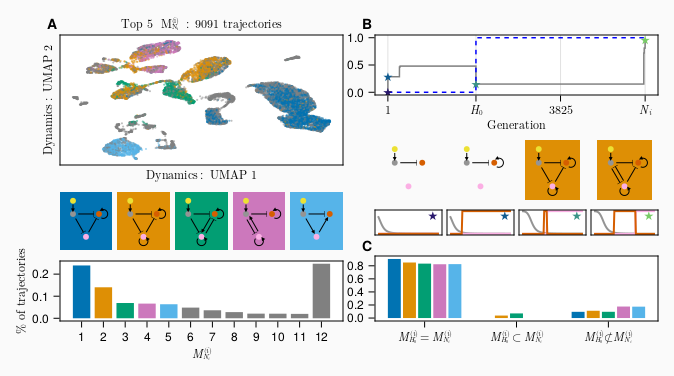

In [341]:
include(srcdirx("AnalysisVisualization.jl"))

fontsize_pub = 12.

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (674,424-(4*12)),fontsize = fontsize_pub)

# dynamical_summary_config(fontsize,embed_markersize,color_scheme,node_colors,draw_config,fitness_linewidth,fitness_markersize,pheno_linewidth,color_fade,caption_padding,caption_fontsize)

ds_config_12 = dynamical_summary_config(fontsize_pub,3.,top_n_colors,node_colors1,draw_config_12,1.5,12.,2.,1.,2.5,14.)

plot_dynamical_summary!(fig,trajectories,embedding,top_n,min_n,sorted_uep,sorted_counts_uep,end_parents,vertex_top_map,example_mst,tr_choice,ds_config_12)

cond_save(plotsdirx(plot_save_dir,"DynamicalSummary.pdf"),fig,true)

fig

In [49]:
trajectories_p_d = filter(tr->tr.inc_metagraph_vertices[end] ∈ sorted_uep[1:top_n],trajectories);

trajectories_p_end = filter(tr->tr.inc_metagraph_vertices[end] == tr.inc_metagraph_vertices[tr.H0],trajectories_p_d);

length(trajectories_p_end)

7864

In [50]:
all_dets = []
all_volumes = []
all_sigma = []

for n in 1:top_n

    pop = filter(tr->tr.inc_metagraph_vertices[end] == sorted_uep[n],trajectories_p_d)

    pop_geno = map(tr->tr.geno_traj[end],pop)

    # clique_hull = convex_hull(pop_geno);

    # P1 = VPolytope(clique_hull);

    # P1_vol = LazySets.volume(P1)

    # x = sum(clique_hull_1)/length(clique_hull_1);

    data_matrix = reduce(hcat,pop_geno)[1:10,:]

    fit_mv = Distributions.fit(MvNormal,data_matrix)

    push!(all_dets,det(fit_mv.Σ))
    push!(all_sigma,fit_mv.Σ)

end

In [51]:
all_wait_times = reduce(hcat,[cumulative_wait_time(tr) for tr in trajectories_p_end]);

In [52]:
for tr in trajectories_p_end
    evaluate_epistasis_types!(tr,grn_parameters,DefaultGRNSolver(),fitness_function)
end

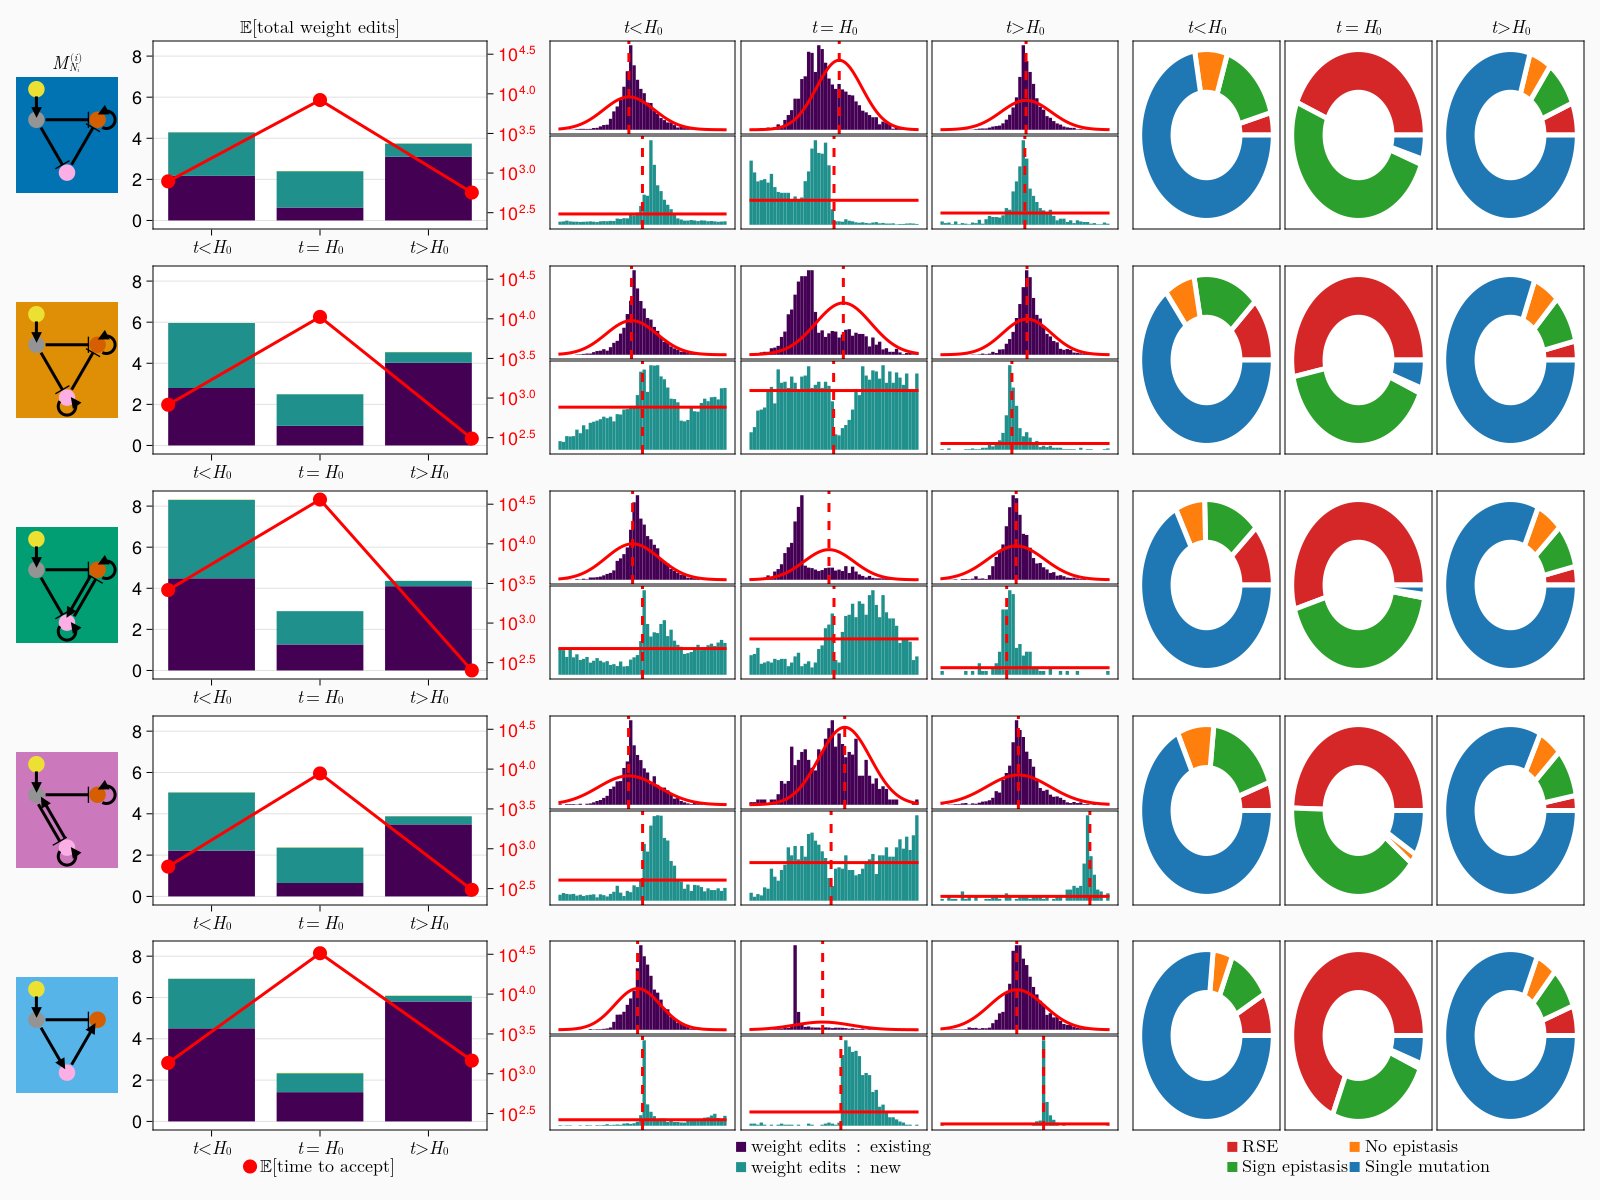

In [314]:
include(srcdirx("AnalysisVisualization.jl"))

# evo_config = evo_summary_config(fontsize,wait_markersize,wait_linewidth,color_scheme,node_colors,draw_config,color_fade,pie_radius,pie_inner_radius,pie_colors,pie_strokewidth)

evo_config_18 = evo_summary_config(fontsize,20.,3.,top_n_colors,node_colors1,draw_config_18,1.,4.,2.,reverse(palette(:tab10)[1:4]),5.)

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1600, 1200),fontsize = fontsize)

create_evo_summary!(fig,trajectories_p_end,top_n,mutation_op,sorted_uep, vertex_top_map,evo_config_18)

cond_save(plotsdirx(plot_save_dir,"EvoSummary.png"),fig,save_fig)

fig


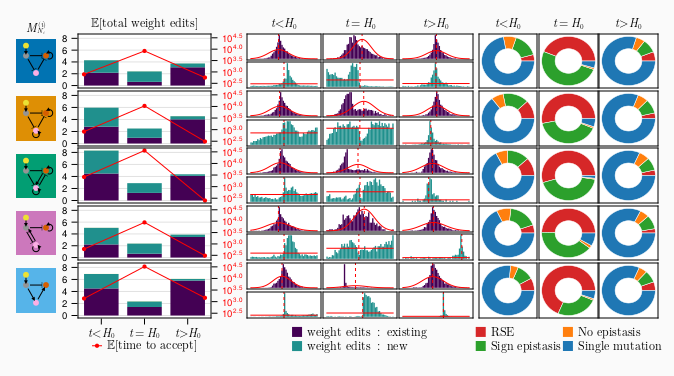

In [322]:
include(srcdirx("AnalysisVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (674,424-(4*12)),fontsize = fontsize_pub)

# evo_config = evo_summary_config(fontsize,wait_markersize,wait_linewidth,color_scheme,node_colors,draw_config,color_fade,pie_radius,pie_inner_radius,pie_colors,pie_strokewidth)

evo_config_12 = evo_summary_config(fontsize_pub,6.,1.,top_n_colors,node_colors1,draw_config_12,1.,4.,2.,reverse(palette(:tab10)[1:4]),0.5)

create_evo_summary!(fig,trajectories_p_end,top_n,mutation_op,sorted_uep,vertex_top_map,evo_config_12)

cond_save(plotsdirx(plot_save_dir,"EvoSummary.pdf"),fig,true)

fig

In [54]:
sum([tr.minimal_stripe_subgraphs[tr.H0] == tr.minimal_stripe_subgraphs[end] for tr in trajectories_p_end])/length(trajectories_p_end)

1.0

In [328]:
include(srcdirx("AnalysisVisualization.jl"))

plot_mst_explanation! (generic function with 1 method)

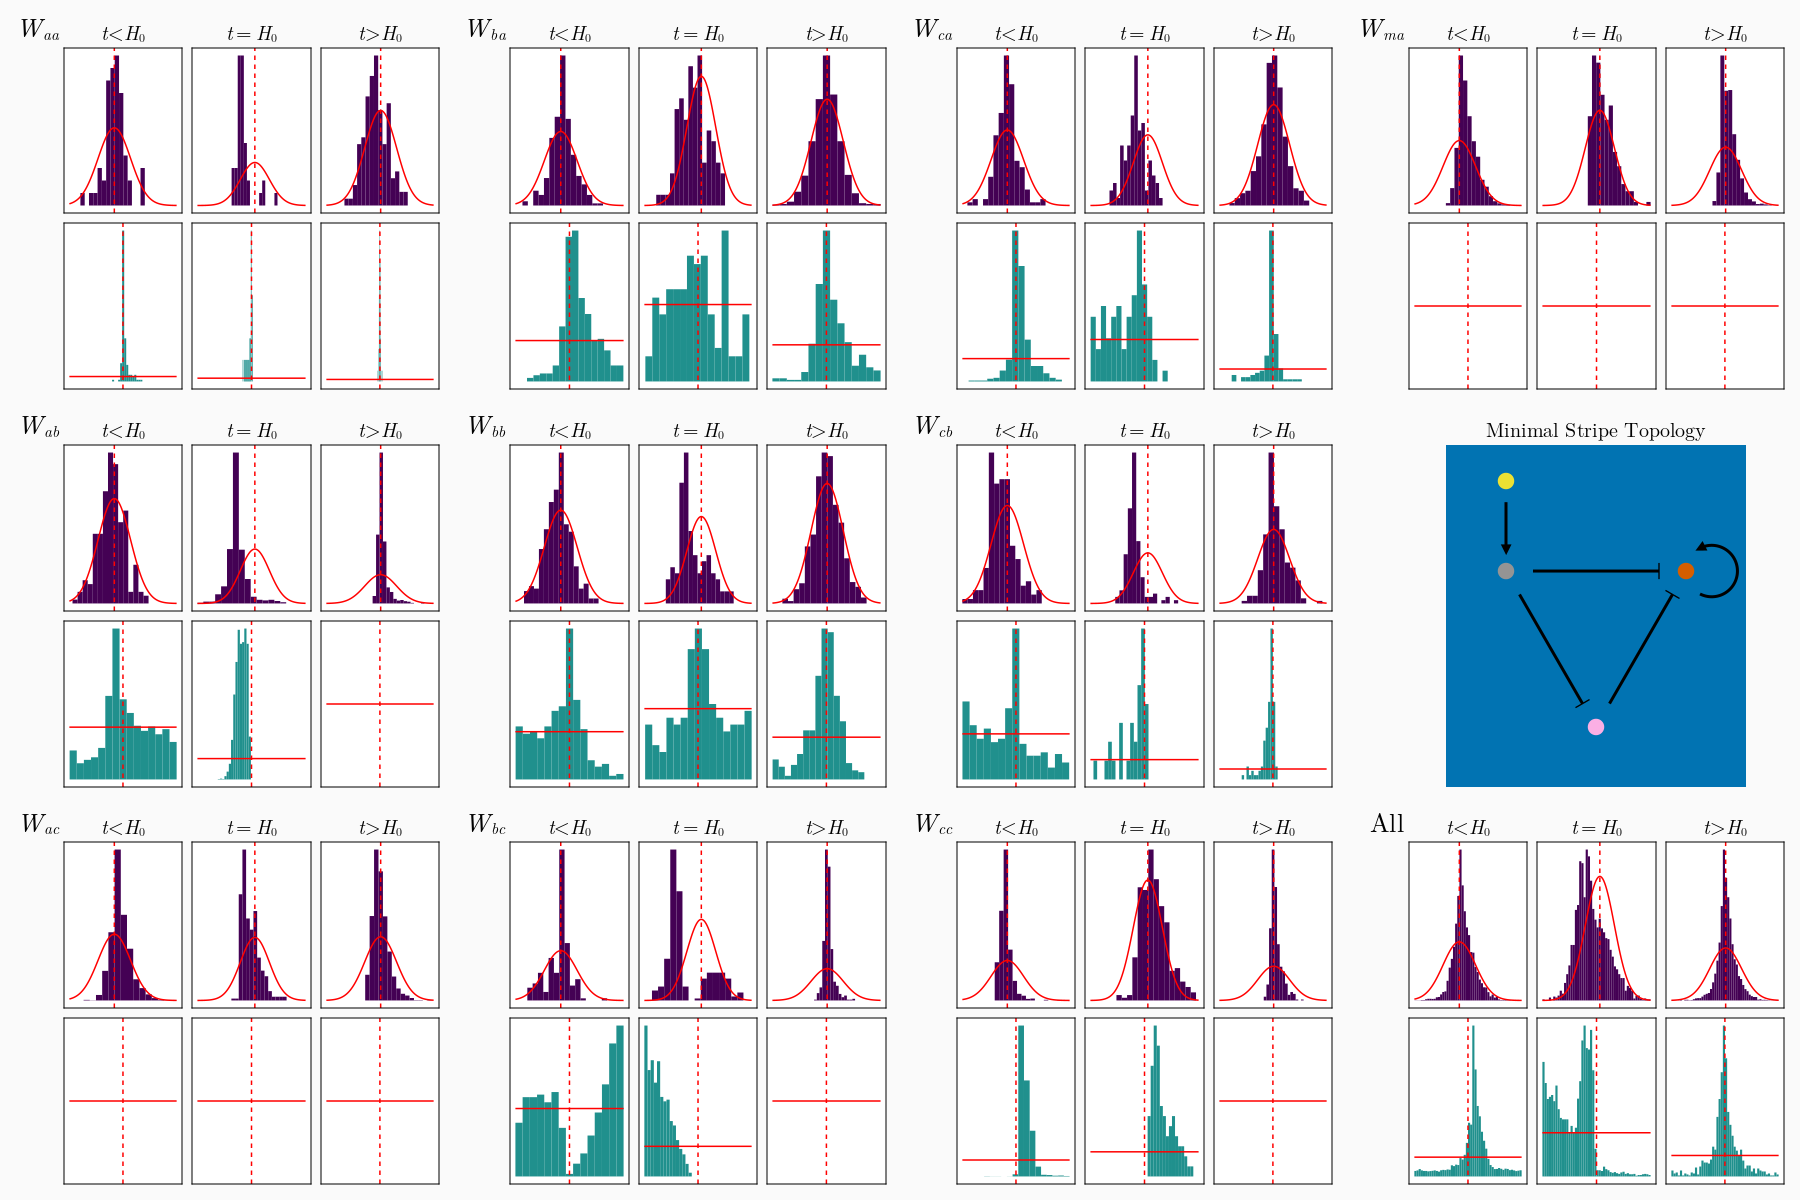

In [329]:
n = 1

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1800, 1200),fontsize = 20.)

create_weight_edit_summary!(fig,n,trajectories_p_end,mutation_op,sorted_uep, vertex_top_map, draw_config_18, node_colors1,fontsize,top_n_colors)

cond_save(plotsdirx(plot_save_dir,"WeightEditSummary_" * string(n) * ".png"),fig,save_fig)

fig

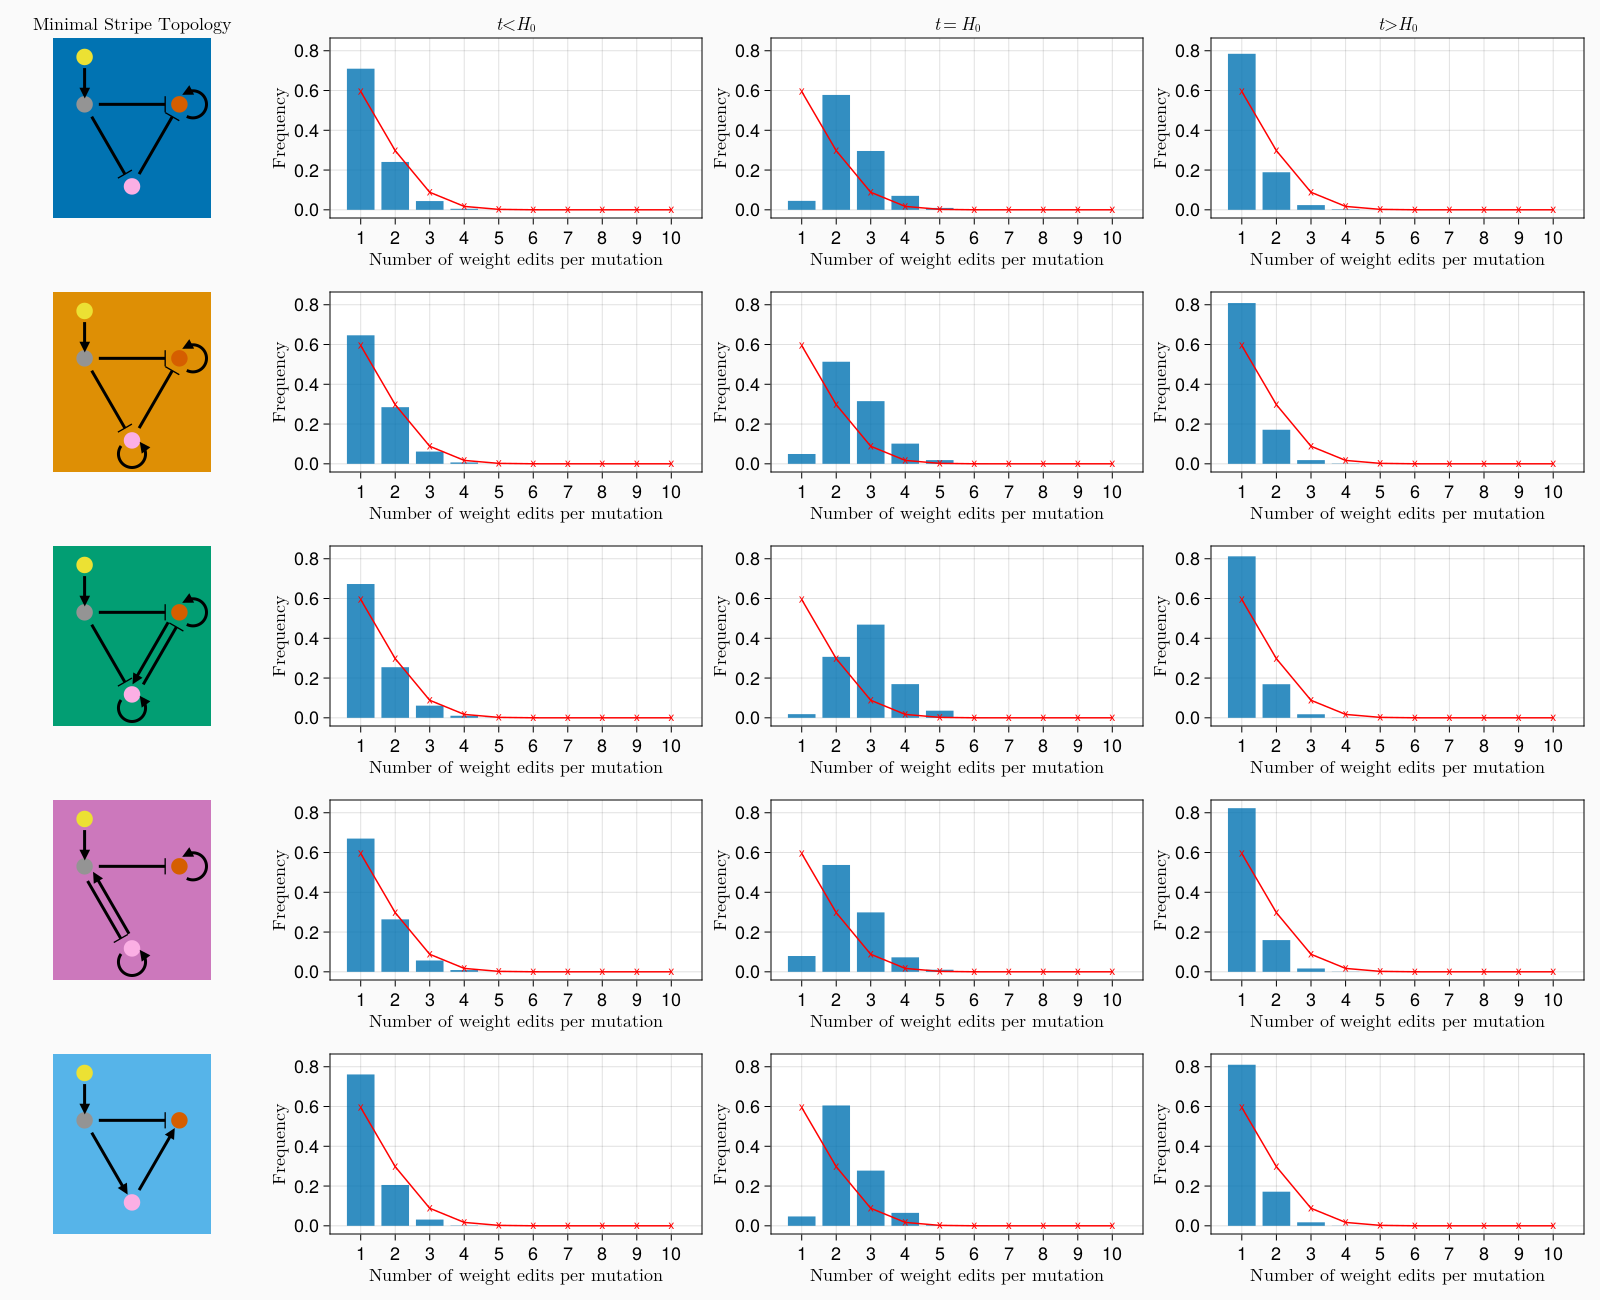

In [330]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1600, 1300),fontsize = 18.)

create_mutation_number_summary!(fig,trajectories,top_n,mut_prob,sorted_uep, vertex_top_map, draw_config_18,node_colors1,fontsize,top_n_colors)

cond_save(plotsdirx(plot_save_dir,"MutationNumberSummary.png"),fig,save_fig)

fig

In [57]:
# #VIM analysis => in what cases is it linked to SE, in the sense that if we remove the hitchhiker, does it constrain the future as much (delta entropy for hitchhiker removal)?

In [58]:
trajectories_p_incl = filter(tr->Bool(test_inclusion(tr.minimal_stripe_subgraphs[end],tr.minimal_stripe_subgraphs[tr.H0])) & !(tr.minimal_stripe_subgraphs[end] == tr.minimal_stripe_subgraphs[tr.H0]) ,trajectories_p_d);

trajectories_p_shift = filter(tr->!Bool(test_inclusion(tr.minimal_stripe_subgraphs[end],tr.minimal_stripe_subgraphs[tr.H0])),trajectories_p_d);

@assert length(trajectories_p_shift) + length(trajectories_p_incl) + length(trajectories_p_end) == length(trajectories_p_d)

In [59]:
trajectories_p_shift_nrv = filter(tr->!Bool(test_inclusion(tr.minimal_stripe_subgraphs[tr.H0],tr.minimal_stripe_subgraphs[end])),trajectories_p_shift);

(length(trajectories_p_shift) - length(trajectories_p_shift_nrv)) / length(trajectories_p_shift)

0.6604127579737336

In [60]:
length(trajectories_p_shift_nrv)

362

In [61]:
shift_vertices_H0 = map(tr->tr.inc_metagraph_vertices[tr.H0], trajectories_p_shift_nrv)
shift_vertices_end = map(tr->tr.inc_metagraph_vertices[end],trajectories_p_shift_nrv);

shift_parents_H0 = map(tr->tr.inc_metagraph_parents[tr.H0], trajectories_p_shift_nrv)
shift_parents_end = map(tr->tr.inc_metagraph_parents[end],trajectories_p_shift_nrv);

unique_sp_H0 = sort(unique(shift_parents_H0))
unique_sp_end = sort(unique(shift_parents_end))

shift_tm = zeros(length(unique_sp_H0),length(unique_sp_end))

for i in 1:length(unique_sp_H0)
    for j in 1:length(unique_sp_end)
        shift_tm[i,j] = count(x->(x[1] == unique_sp_H0[i]) & (x[2] == unique_sp_end[j]),zip(shift_parents_H0,shift_parents_end))
    end
end

# unique_trans = unique(zip(shift_vertices_H0,shift_vertices_end) |> collect)

# count_unique_trans = [count(t->t==ut,zip(shift_vertices_H0,shift_vertices_end) |> collect) for ut in unique_trans]

# sort_unique_trans_id = sortperm(count_unique_trans, rev = true)

# zip(unique_trans[sort_unique_trans_id],count_unique_trans[sort_unique_trans_id]) |> collect

unique_trans = unique(zip(shift_parents_H0,shift_parents_end) |> collect)

count_unique_trans = [count(t->t==ut,zip(shift_parents_H0,shift_parents_end) |> collect) for ut in unique_trans]

sort_unique_trans_id = sortperm(count_unique_trans, rev = true)

zip(unique_trans[sort_unique_trans_id],count_unique_trans[sort_unique_trans_id]) |> collect

8-element Vector{Tuple{Tuple{Int64, Int64}, Int64}}:
 ((25, 3), 151)
 ((3, 25), 122)
 ((3, 3), 66)
 ((17, 1), 19)
 ((167, 25), 1)
 ((94, 1), 1)
 ((59, 3), 1)
 ((194, 3), 1)

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = 20.)

example_id = 200

# Plotted on twin axis

twin_axis = true

plot_mst_explanation!(fig,trajectories_p_end,example_id,draw_config,fs18_default,node_colors,fontsize,false,twin_axis)

cond_save(plotsdirx(plot_save_dir,"MSTExample_" * string(example_id) * ".png"),fig,save_fig)

fig

In [62]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000,500),fontsize = 20.)

example_id = 7102

twin_axis = true

plot_mst_explanation!(fig,trajectories_p_end,example_id,draw_config,fs18_default,node_colors,fontsize,false,twin_axis)

cond_save(plotsdirx(plot_save_dir,"MSTExample_" * string(example_id) * ".png"),fig,save_fig)

fig

UndefVarError: UndefVarError: development not defined

In [63]:
predict_id = sorted_uep[1:top_n]

label_names = [1,2,3,4,5]

trajectories_p = filter(tr->tr.inc_metagraph_vertices[tr.H0] ∈ predict_id,trajectories);

vertex_to_predict_label = Dict(vertex=>n for (n,vertex) in enumerate(predict_id))

predict_label_to_vertex = Dict(n=>vertex for (n,vertex) in enumerate(predict_id))

label = map(tr->vertex_to_predict_label[tr.inc_metagraph_vertices[tr.H0]],trajectories_p);

label_mss = reduce(hcat,map(tr->tr.minimal_stripe_subgraphs[tr.H0],trajectories_p)) |> transpose |> collect;

label_mss_all = reduce(hcat,map(tr->tr.minimal_stripe_subgraphs[tr.H0],trajectories)) |> transpose |> collect;

In [64]:
end_parents_H0 = map(tr->tr.inc_metagraph_vertices[tr.H0],trajectories)

sorted_uep_H0,sorted_counts_uep_H0 = return_order_by_count(end_parents_H0);

sorted_uep_H0_dict = Dict(v=>n for (v,n) in zip(sorted_uep_H0,sorted_counts_uep_H0))

null_H0_temp = [sorted_uep_H0_dict[i] for i in predict_id]

null_H0_dist = vcat(null_H0_temp,[length(end_parents_H0 ) - sum(null_H0_temp)]) ./ length(end_parents_H0);


In [65]:
train_id,test_id =  create_train_test_id_split(label,0.8);
save("train_test_ids.jld2", Dict("train" => train_id, "test" => test_id))

train_id_mss,test_id_mss = create_train_test_id_split_multilabel(label_mss,0.8);

save("train_test_ids_mss.jld2", Dict("train" => train_id_mss, "test" => test_id_mss))

train_id_mss_all,test_id_mss_all = create_train_test_id_split_multilabel(label_mss_all,0.8);

save("train_test_ids_mss_all.jld2", Dict("train" => train_id_mss_all, "test" => test_id_mss_all))

In [66]:
# train_id = load("train_test_ids.jld2", "train")
# test_id = load("train_test_ids.jld2", "test");

# train_id_mss = load("train_test_ids_mss.jld2", "train")
# test_id_mss  = load("train_test_ids_mss.jld2", "test");

# train_id_mss_all = load("train_test_ids_mss_all.jld2", "train")
# test_id_mss_all  = load("train_test_ids_mss_all.jld2", "test");

In [67]:
X_train_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(label[train_id],trajectories_p[train_id])]
X_train_ttl = reduce(hcat,X_train_ttl_v) |> transpose |> collect

y_train_ttl = copy(Int.(X_train_ttl[:,13]))

X_train_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(label[train_id],trajectories_p[train_id])]
X_train_gtl  = reduce(hcat,X_train_gtl_v) |> transpose |> collect;

y_train_gtl = copy(Int.(X_train_gtl[:,13]))

X_train_mss_v = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories_p[train_id_mss]]
X_train_mss = reduce(hcat,X_train_mss_v) |> transpose |> collect;

y_train_mss = copy(Int.(X_train_mss[:,13:end-2]))

###################

X_test_ttl_v = [reduce(hcat,unique([vcat(features,label) for features in tr.topologies[1:tr.H0-1]])) for (label,tr) in zip(label[test_id],trajectories_p[test_id])]
X_test_ttl = reduce(hcat,X_test_ttl_v) |> transpose |> collect

y_test_ttl = copy(Int.(X_test_ttl[:,13]))

X_test_gtl_v = [reduce(hcat,[vcat(features,label) for features in tr.geno_traj[1:tr.H0-1]]) for (label,tr) in zip(label[test_id],trajectories_p[test_id])]
X_test_gtl  = reduce(hcat,X_test_gtl_v) |> transpose |> collect;

y_test_gtl = copy(Int.(X_test_gtl[:,13]))

X_test_mss_v = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories_p[test_id_mss]]
X_test_mss = reduce(hcat,X_test_mss_v) |> transpose |> collect;

y_test_mss = copy(Int.(X_test_mss[:,13:end-2]));

###################

X_train_mss_v_all = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories[train_id_mss_all]]
X_train_mss_all = reduce(hcat,X_train_mss_v_all) |> transpose |> collect;

y_train_mss_all = copy(Int.(X_train_mss_all[:,13:end-2]))

X_test_mss_v_all = [reduce(hcat,[vcat(features,tr.minimal_stripe_subgraphs[tr.H0]) for features in tr.geno_traj]) for tr in trajectories[test_id_mss_all]]
X_test_mss_all = reduce(hcat,X_test_mss_v_all) |> transpose |> collect;

y_test_mss_all = copy(Int.(X_test_mss_all[:,13:end-2]));

In [68]:
for id in train_id
    trajectories_p[id].train_test_indicator = :train
end

for id in test_id
    trajectories_p[id].train_test_indicator = :test
end

for id in train_id_mss
    trajectories_p[id].train_test_indicator_mss  = :train
end

for id in test_id_mss
    trajectories_p[id].train_test_indicator_mss  = :test
end

for id in train_id_mss_all
    trajectories[id].train_test_indicator_mss  = :train
end

for id in test_id_mss_all
    trajectories[id].train_test_indicator_mss  = :test
end

In [69]:
const c_types = ["c" for _ in 1:10];

In [70]:
class_counts_train = [count(v->v==var,y_train_ttl) for var in label_names]
class_weights_train = minimum(class_counts_train) ./ class_counts_train
class_weight_train_instances = map(x->class_weights_train[x],y_train_ttl);

c_types = ["c" for _ in 1:10];

d_train_ttl = xgboost.DMatrix(X_train_ttl[:,1:10], label=y_train_ttl .- 1,feature_types = c_types, feature_names = weight_names, weight = class_weight_train_instances)
d_test_ttl = xgboost.DMatrix(X_test_ttl[:,1:10], label=y_test_ttl .- 1,feature_types = c_types, feature_names = weight_names)

params = Dict(
    "eta"=> 0.01,
    "objective"=>"multi:softprob",
    "num_class"=>top_n,
    "subsample"=> 0.5,
    "eval_metric"=>"auc"
)

model_ttl = xgboost.train(params, d_train_ttl, 5000, evals = [(d_test_ttl, "test")], verbose_eval=false, early_stopping_rounds=200)

y_pred_train_ttl = mapslices(x->argmax(x),model_ttl.predict(d_train_ttl),dims = 2)
y_pred_test_ttl = mapslices(x->argmax(x),model_ttl.predict(d_test_ttl),dims = 2);

print(sum(y_pred_test_ttl .== y_test_ttl) / length(y_test_ttl))

model_ttl.save_model("ModelTTL.json")

0.5262426138338547

In [71]:
# model_ttl = xgboost.Booster()
# model_ttl.load_model("ModelTTL.json")

In [72]:
class_counts_train = [count(v->v==var,y_train_gtl) for var in label_names]
class_weights_train = minimum(class_counts_train) ./ class_counts_train
class_weight_train_instances = map(x->class_weights_train[x],y_train_gtl);

d_train_gtl = xgboost.DMatrix(X_train_gtl[:,1:10], label=y_train_gtl .- 1,feature_names = weight_names, weight = class_weight_train_instances)
d_test_gtl = xgboost.DMatrix(X_test_gtl[:,1:10], label=y_test_gtl .- 1,feature_names = weight_names)

params = Dict(
    "eta"=> 0.01,
    "objective"=>"multi:softprob",
    "num_class"=>top_n,
    "subsample"=> 0.5,
    "eval_metric"=>"auc"
)

model_gtl = xgboost.train(params, d_train_gtl, 5000, evals = [(d_test_gtl, "test")], verbose_eval=false, early_stopping_rounds=200)

y_pred_train_gtl = mapslices(x->argmax(x),model_gtl.predict(d_train_gtl),dims = 2)
y_pred_test_gtl = mapslices(x->argmax(x),model_gtl.predict(d_test_gtl),dims = 2);

print(sum(y_pred_test_gtl .== y_test_gtl) / length(y_test_gtl))

model_gtl.save_model("ModelGTL.json")

0.5928540864356012

In [73]:
# model_gtl = xgboost.Booster()
# model_gtl.load_model("ModelGTL.json")

In [343]:
# all_models_mss = []

# for i in 1:size(y_train_mss,2)

#     print(i)

#     unique_labels = unique(y_train_mss[:,i] .+ 2)

#     num_class = length(unique_labels)

#     class_counts_train = [count(v->v==var,y_train_mss[:,i] .+ 2) for var in [1,2,3]]

#     class_weights_train = minimum(class_counts_train[unique_labels]) ./ class_counts_train
    
#     class_weight_train_instances = map(x->class_weights_train[x],y_train_mss[:,i] .+ 2);

#     d_train = xgboost.DMatrix(X_train_mss[:,1:10], label=y_train_mss[:,i] .+ 1,  feature_names = weight_names, weight = class_weight_train_instances)
#     d_test = xgboost.DMatrix(X_test_mss[:,1:10], label=y_test_mss[:,i] .+ 1, feature_names = weight_names)

#     params = Dict(
#         "eta"=> 0.01,
#         "objective"=>"multi:softprob",
#         "num_class"=>3,
#         "subsample"=> 0.5,
#         "eval_metric"=>"auc"
#     )
        
#     model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=false, early_stopping_rounds=200)

#     push!(all_models_mss,model)

#     model.save_model("Weight_" * string(i) * ".json")
# end

all_models_mss = []

for j in 1:10
    m = xgboost.Booster()
    m.load_model("Weight_"* string(j) * ".json")
    push!(all_models_mss,m)
end

In [75]:
# all_models_mss_all = []

# for i in 1:size(y_train_mss_all,2)

#     print(i)

#     unique_labels = unique(y_train_mss_all[:,i] .+ 2)

#     num_class = length(unique_labels)

#     class_counts_train = [count(v->v==var,y_train_mss_all[:,i] .+ 2) for var in [1,2,3]]

#     class_weights_train = minimum(class_counts_train[unique_labels]) ./ class_counts_train
    
#     class_weight_train_instances = map(x->class_weights_train[x],y_train_mss_all[:,i] .+ 2);

#     d_train = xgboost.DMatrix(X_train_mss_all[:,1:10], label=y_train_mss_all[:,i] .+ 1,  feature_names = weight_names, weight = class_weight_train_instances)
#     d_test = xgboost.DMatrix(X_test_mss_all[:,1:10], label=y_test_mss_all[:,i] .+ 1, feature_names = weight_names)

#     params = Dict(
#         "eta"=> 0.01,
#         "objective"=>"multi:softprob",
#         "num_class"=>3,
#         "subsample"=> 0.5,
#         "eval_metric"=>"auc"
#     )
        
#     model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=false, early_stopping_rounds=200)

#     model.save_model("Weight_" * string(i) * "_All.json")
# end

# all_models_mss_all = []

# for j in 1:10
#     m = xgboost.Booster()
#     m.load_model("Weight_"* string(j) * "_All.json")
#     push!(all_models_mss_all,m)
# end

In [76]:
# save(train_id)

In [77]:
for tr in trajectories_p
    assign_predictions!(tr,model_ttl,:tt,predict_label_to_vertex)
    assign_predictions!(tr,model_gtl,:gt,predict_label_to_vertex)
    assign_predictions!(tr,all_models_mss,:mss)
end

for (tr,label) in zip(trajectories_p,label)
    assign_tt_prediction_errors!(tr,predict_label_to_vertex[label])
    assign_gt_prediction_errors!(tr,predict_label_to_vertex[label])
end

for tr in trajectories_p
    assign_mss_prediction_errors!(tr,Hamming())
end

In [78]:
# for tr in trajectories
#     assign_predictions!(tr,all_models_mss_all,:mss)
# end

# for tr in trajectories
#     assign_mss_prediction_errors!(tr,Hamming())
# end

In [79]:
sum([tr.minimal_stripe_subgraphs[tr.H0] == tr.minimal_stripe_subgraphs[end] for tr in trajectories])

12356

In [80]:
for tr in trajectories_p
    assign_weight_edits!(tr)
end

In [81]:
max_ce = maximum(map(tr->tr.top_edits[tr.H0-1],trajectories_p))

11

In [351]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (1200, 600),fontsize = 20.)

# ax_train = Axis(fig[1,1], xlabel = L"\text{Cumulative topological edits}",title = "Topological information")
# ax_test = Axis(fig[1,2],xlabel = L"\text{Cumulative topological edits}")
# ax_entropy = Axis(fig[2,1:2],xlabel = L"\text{Cumulative topological edits}")

# all_bar_counts = []
# all_bar_stack = []
# all_bar_x = []

# total_tr = 0
# total_te = 0

# max_ce = maximum(map(tr->tr.top_edits[tr.H0],trajectories_p))

# pop = filter(tr->tr.train_test_indicator == :train,trajectories_p)

# for r in 1:max_ce
    
#     pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

#     pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

#     accuracies  = map(tr->v_restricted_accuracy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

#     mean_ent = map(tr->v_restricted_entropy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

#     bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

#     bar_stack = [1,2,3]

#     bar_x = [r,r,r]

#     push!(all_bar_counts,bar_counts)
#     push!(all_bar_stack,bar_stack)
#     push!(all_bar_x,bar_x)

# end

# all_bar_counts = reduce(vcat,all_bar_counts)
# all_bar_stack = reduce(vcat,all_bar_stack)
# all_bar_x = reduce(vcat,all_bar_x);

# CairoMakie.barplot!(ax_train,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

# ################################

# all_bar_counts = []
# all_bar_stack = []
# all_bar_x = []

# total_tr = 0
# total_te = 0

# max_ce = maximum(map(tr->tr.top_edits[tr.H0],trajectories_p))

# pop = filter(tr->tr.train_test_indicator == :test,trajectories_p)

# all_mean_ent = []

# for r in 1:max_ce
    
#     pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

#     pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->top_edit_restriction_measure(x,r),:H0),pop)

#     accuracies  = map(tr->v_restricted_accuracy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

#     mean_ent = map(tr->v_restricted_entropy(tr,x->top_edit_restriction_measure(x,r),:tt),pop_not_achieved)

#     if length(mean_ent) > 2
#         hist!(ax_entropy, mean_ent, scale_to= 0.6, offset=r, direction=:x)
#         push!(all_mean_ent,mean(mean_ent))
#     end

#     bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

#     bar_stack = [1,2,3]

#     bar_x = [r,r,r]

#     push!(all_bar_counts,bar_counts)
#     push!(all_bar_stack,bar_stack)
#     push!(all_bar_x,bar_x)

# end

# CairoMakie.lines!(Float64.(all_mean_ent),color = :red)
# CairoMakie.scatter!(Float64.(all_mean_ent),color = :red)

# all_bar_counts = reduce(vcat,all_bar_counts)
# all_bar_stack = reduce(vcat,all_bar_stack)
# all_bar_x = reduce(vcat,all_bar_x);

# CairoMakie.barplot!(ax_test,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

# linkyaxes!(ax_train,ax_test)

# ax_train.xticks = (1:max_ce,string.(1:max_ce))
# ax_test.xticks = (1:max_ce,string.(1:max_ce))
# ax_entropy.xticks = (1:max_ce,string.(1:max_ce))

# fig

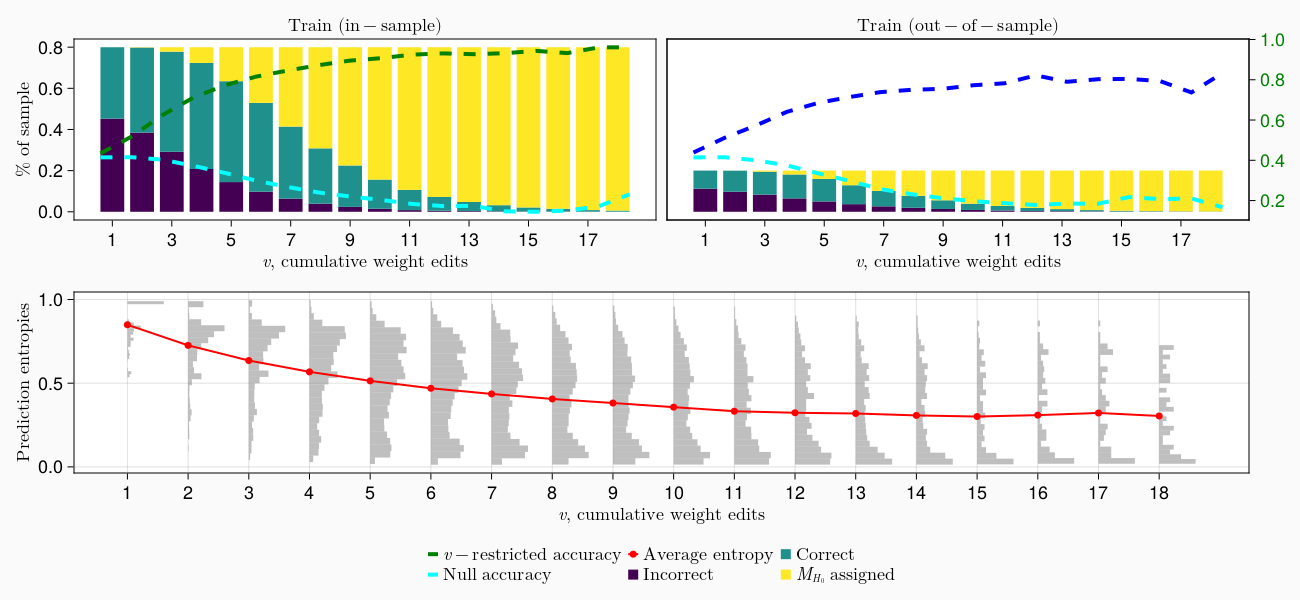

In [405]:
include(srcdirx("AnalysisVisualization.jl"))
include(srcdirx("GRNVisualization.jl"))

fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1300, 600),fontsize = fontsize)

# pred_config(perf_linewidth,entropy_markersize,entropy_linewidth,entropy_hist_scale)

pred_config_18 = pred_config(fontsize,4.,10.,2.,0.6)

create_prediction_summary!(fig,trajectories_p,:gt,18,pred_config_18)

fig

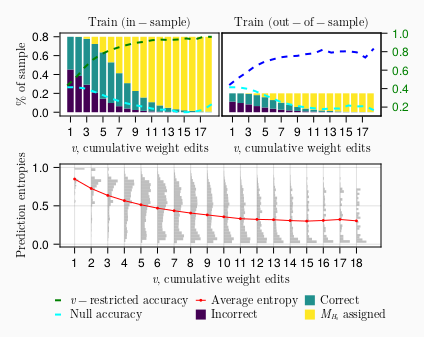

In [398]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (424,floor(674/2)),fontsize = fontsize_pub)

pred_config_12 = pred_config(fontsize_pub,2.,4.,1.,0.6)

create_prediction_summary!(fig,trajectories_p,:gt,18,pred_config_12)

cond_save(plotsdirx(plot_save_dir,"PredSummary.pdf"),fig,true)

fig

In [399]:
# fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
#     resolution = (1200, 600),fontsize = 15.)

# ax_train = Axis(fig[1,1], xlabel = L"\text{Cumulative weight edits}",title = "Weight information - MSS")
# ax_test = Axis(fig[1,2],xlabel = L"\text{Cumulative weight edits}")
# ax_entropy = Axis(fig[2,1:2],xlabel = L"\text{Cumulative weight edits}")

# all_bar_counts = []
# all_bar_stack = []
# all_bar_x = []

# total_tr = 0
# total_te = 0

# max_ce = maximum(map(tr->tr.weight_edits[tr.H0],trajectories_p))

# pop = filter(tr->tr.train_test_indicator == :train,trajectories_p)

# for r in 1:max_ce
    
#     pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

#     pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

#     accuracies  = map(tr->Int(v_restricted_accuracy(tr,x->weight_edit_restriction_measure(x,r),:mss) == 0),pop_not_achieved)

#     mean_ent = map(tr->v_restricted_entropy(tr,x->weight_edit_restriction_measure(x,r),:mss),pop_not_achieved)

#     bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

#     bar_stack = [1,2,3]

#     bar_x = [r,r,r]

#     push!(all_bar_counts,bar_counts)
#     push!(all_bar_stack,bar_stack)
#     push!(all_bar_x,bar_x)

# end

# all_bar_counts = reduce(vcat,all_bar_counts)
# all_bar_stack = reduce(vcat,all_bar_stack)
# all_bar_x = reduce(vcat,all_bar_x);

# CairoMakie.barplot!(ax_train,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

# ################################

# all_bar_counts = []
# all_bar_stack = []
# all_bar_x = []

# total_tr = 0
# total_te = 0

# max_ce = maximum(map(tr->tr.weight_edits[tr.H0],trajectories_p))

# pop = filter(tr->tr.train_test_indicator == :test,trajectories_p)

# all_mean_ent = []

# for r in 1:max_ce
    
#     pop_achieved = filter(tr->v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

#     pop_not_achieved = filter(tr->!v_restricted_label_inclusion(tr,x->weight_edit_restriction_measure(x,r),:H0),pop)

#     accuracies  = map(tr->Int(v_restricted_accuracy(tr,x->weight_edit_restriction_measure(x,r),:mss) == 0),pop_not_achieved)

#     mean_ent = map(tr->v_restricted_entropy(tr,x->weight_edit_restriction_measure(x,r),:mss),pop_not_achieved)

#     if length(mean_ent) > 2
#         hist!(ax_entropy, mean_ent, scale_to= 0.6, offset=r, direction=:x)
#         push!(all_mean_ent,mean(mean_ent))
#     end

#     bar_counts = [count(x->x==0,accuracies),count(x->x==1,accuracies),length(pop_achieved)]

#     bar_stack = [1,2,3]

#     bar_x = [r,r,r]

#     push!(all_bar_counts,bar_counts)
#     push!(all_bar_stack,bar_stack)
#     push!(all_bar_x,bar_x)

# end

# CairoMakie.lines!(Float64.(all_mean_ent),color = :red)
# CairoMakie.scatter!(Float64.(all_mean_ent),color = :red)

# all_bar_counts = reduce(vcat,all_bar_counts)
# all_bar_stack = reduce(vcat,all_bar_stack)
# all_bar_x = reduce(vcat,all_bar_x);

# CairoMakie.barplot!(ax_test,all_bar_x,all_bar_counts,stack = all_bar_stack,color = all_bar_stack)

# linkyaxes!(ax_train,ax_test)

# ax_train.xticks = (1:max_ce,string.(1:max_ce))
# ax_test.xticks = (1:max_ce,string.(1:max_ce))
# ax_entropy.xticks = (1:max_ce,string.(1:max_ce))

# fig

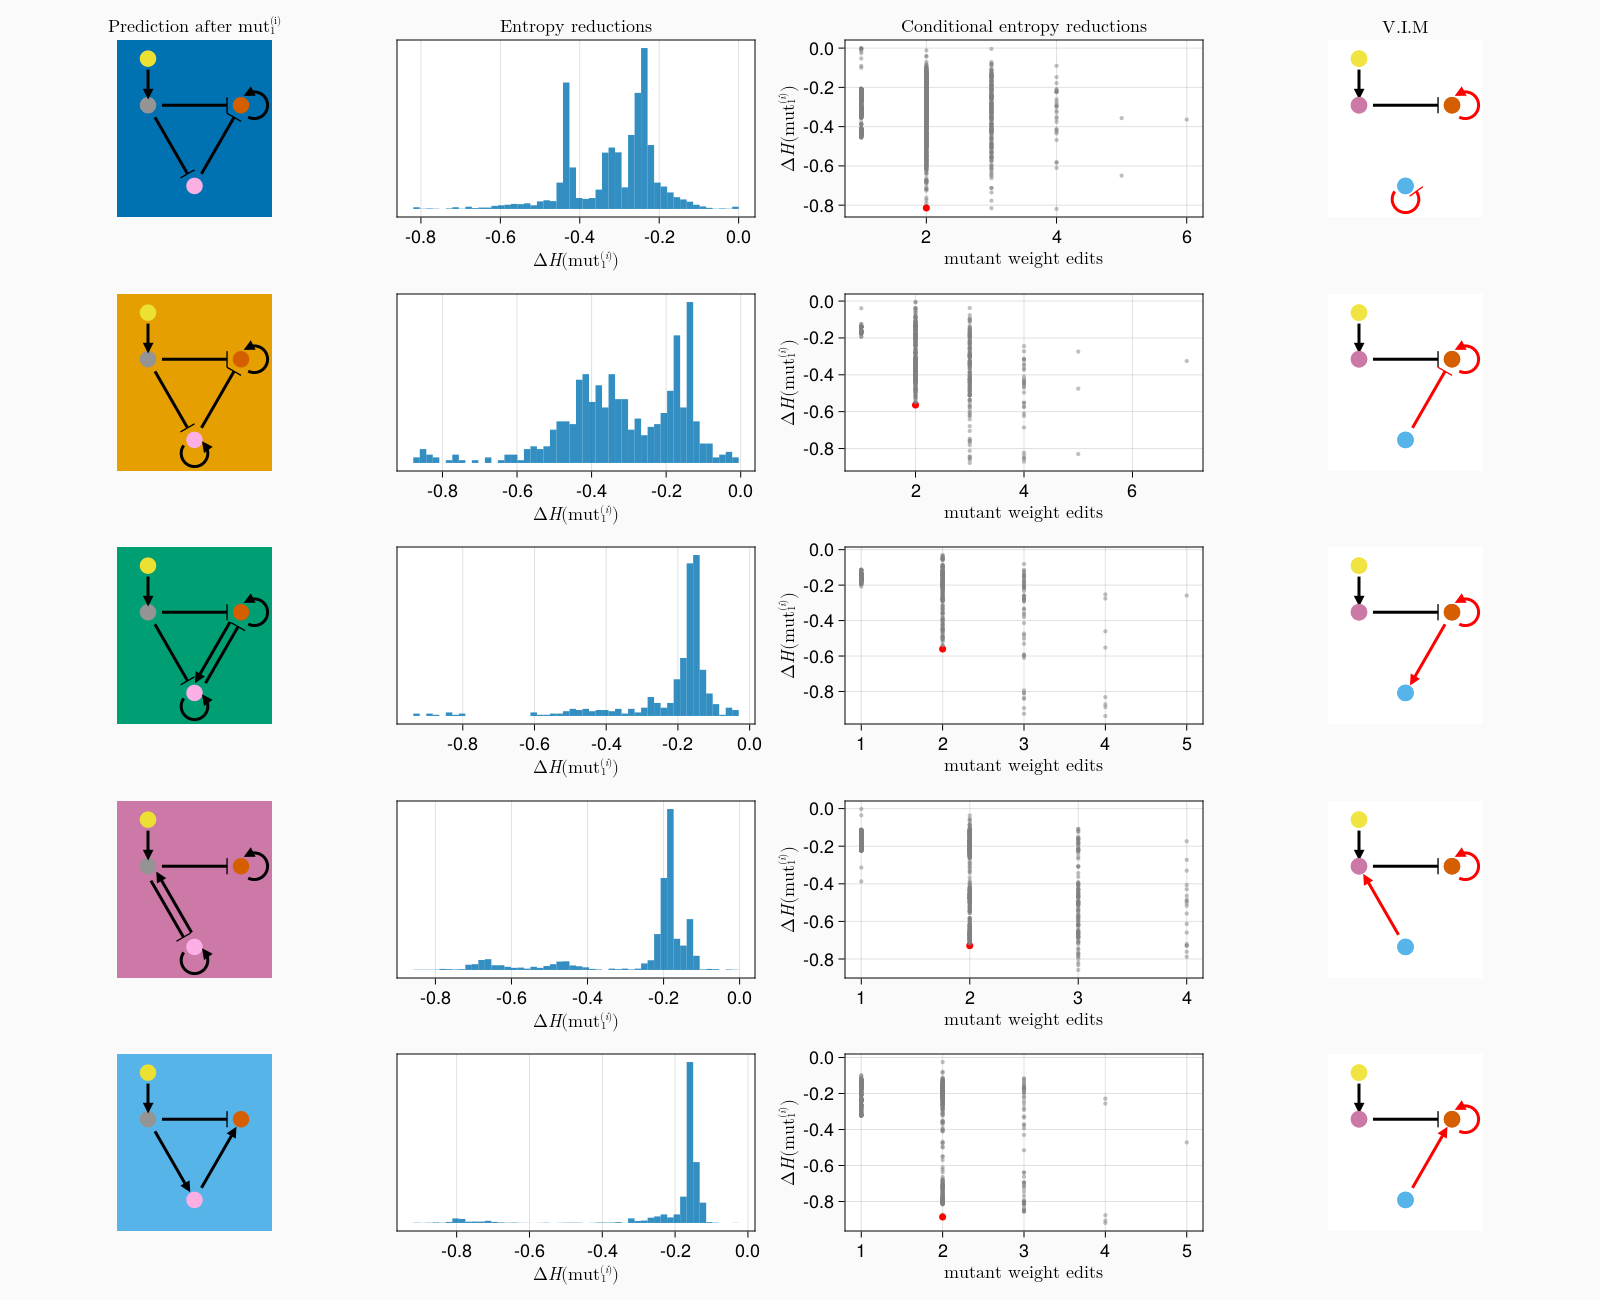

In [413]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1600, 1300),fontsize = 18.)

mut_n = 1

all_target_mutants = []
all_target_networks = []

for n in 1:top_n

    if n == 1
        ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],1.), title = L"\text{Prediction after \text{mut}^{(i)}_{1}}",aspect = DataAspect())

        ax_h = Axis(fig[n,2], title = L"\text{Entropy reductions}", xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], title = L"\text{Conditional entropy reductions}", xlabel = L"\text{mutant weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4], title = L"\text{V.I.M}",aspect = DataAspect())
    else
        ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],1.),aspect = DataAspect())

        ax_h = Axis(fig[n,2], xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], xlabel = L"\text{mutant weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4],aspect = DataAspect())
    end

    sample = filter(tr->tr.gt_label_predictions[mut_n+1] ∈ sorted_uep[n],trajectories_p)

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    # sample_top_edits_deltas = map(tr->map(mi->length(mi[:weight_id]),tr.mutant_info),sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== 2)])

    target_mutant_id = findall(sample_top_edits_delta_select .== 2) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id]

    push!(all_target_mutants,target_mutant)

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))

    CairoMakie.hist!(ax_h,sample_entropy_delta_select ,bins = 50, normalization = :pdf)

    CairoMakie.scatter!(ax_s,sample_top_edits_delta_select,sample_entropy_delta_select ,markersize =  [i == target_mutant_id[1] ? 10. : 6. for i in 1:length(sample_entropy_delta_select)], color = [i == target_mutant_id[1] ? :red : (:grey,0.5) for i in 1:length(sample_entropy_delta_select)])

    draw_grn!(ax_geno,vertex_top_map[sorted_uep[n]],draw_config_18,node_colors1,fontsize,false,false)

    draw_grn_mutant!(ax_geno_m,start_network,resultant_network,draw_config_18,fs18_default,node_colors,fontsize,false,false)

    hideydecorations!(ax_h)

end

fig

In [ ]:
# [0.0 0.0 0.0 1.2490335893436255; 0.0 -0.4653071448603825 0.0 0.0; -0.21577059555519695 0.0 0.8839916974720232 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 9.783420932139212 0.0 0.0; -0.21577059555519695 0.0 2.9843881434554813 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 2.776061959716589 0.16976983631263387 0.0]
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 8.583576419466741 0.0; -0.21577059555519695 0.0 3.651247548915009 0.0]
# [0.0 1.8392494930551262 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 2.202901463495671 0.0]

test_networks = map(x->reshape(x[2],(3,4)), all_target_networks)

In [ ]:
all_top_msn = []

all_top_msn_counts = []

vim_trajectories = []
vim_vertex_top_map = []

for n in 1:top_n

    print(n)

    data_con = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_Contingent_" * string(n) * "_RawData.jld2"));

    conv_con = copy(data_con["converged"]);

    nconv_con = sum(conv_con)

    fs_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_fs_networks"])
    ls_mss_con =  map(list_mss->select_minimal_topologies(list_mss),data_con["min_end_networks"]);

    trajectories_con = map(n->Trajectory(n,data_con["geno_traj"][conv_con][n],data_con["fitness_traj"][conv_con][n],data_con["mut_type"][conv_con][n]),1:nconv_con);

    for (n,tr) in enumerate(trajectories_con)
        assign_minimal_subgraphs!(tr,fs_mss_con[n],ls_mss_con[n])
    end

    inc_metagraph_con, vertex_top_map_con,top_vertex_map_con,vertex_complexity_map_con,inclusion_matrix_con = create_inclusion_metagraph(trajectories_con);

    minimal_motif_id_con = findall(indegree(inc_metagraph_con) .== 0);

    minimal_motifs_con = reduce(hcat,[vertex_top_map_con[vertex_id] for vertex_id in minimal_motif_id_con]);

    for tr in trajectories_con
        assign_inc_vertex_ids!(tr,top_vertex_map_con)
        assign_inc_parents!(tr,inclusion_matrix_con,vertex_complexity_map_con,minimal_motif_id_con)
    end

    push!(vim_trajectories,trajectories_con)
    push!(vim_vertex_top_map,vertex_top_map_con)

    # end_parents_con = map(tr->tr.inc_metagraph_vertices[tr.H0],trajectories_con)
    # end_msn_con = map(tr->tr.minimal_stripe_subgraph[tr.H0],trajectories_con)

    # sorted_uep_con,sorted_counts_uep_con = return_order_by_count(end_parents_con);

    # top_msn = [vertex_top_map_con[sorted_uep_con[i]] for i in 1:top_n]

    # push!(all_top_msn,top_msn)
    # push!(all_top_msn_counts,sorted_counts_uep_con[1:top_n])

    # for k in 1:top_n
    #     top_to_check = vertex_top_map[sorted_counts_uep[k]]
    #     map(msn->test_iend_msn_con)

end


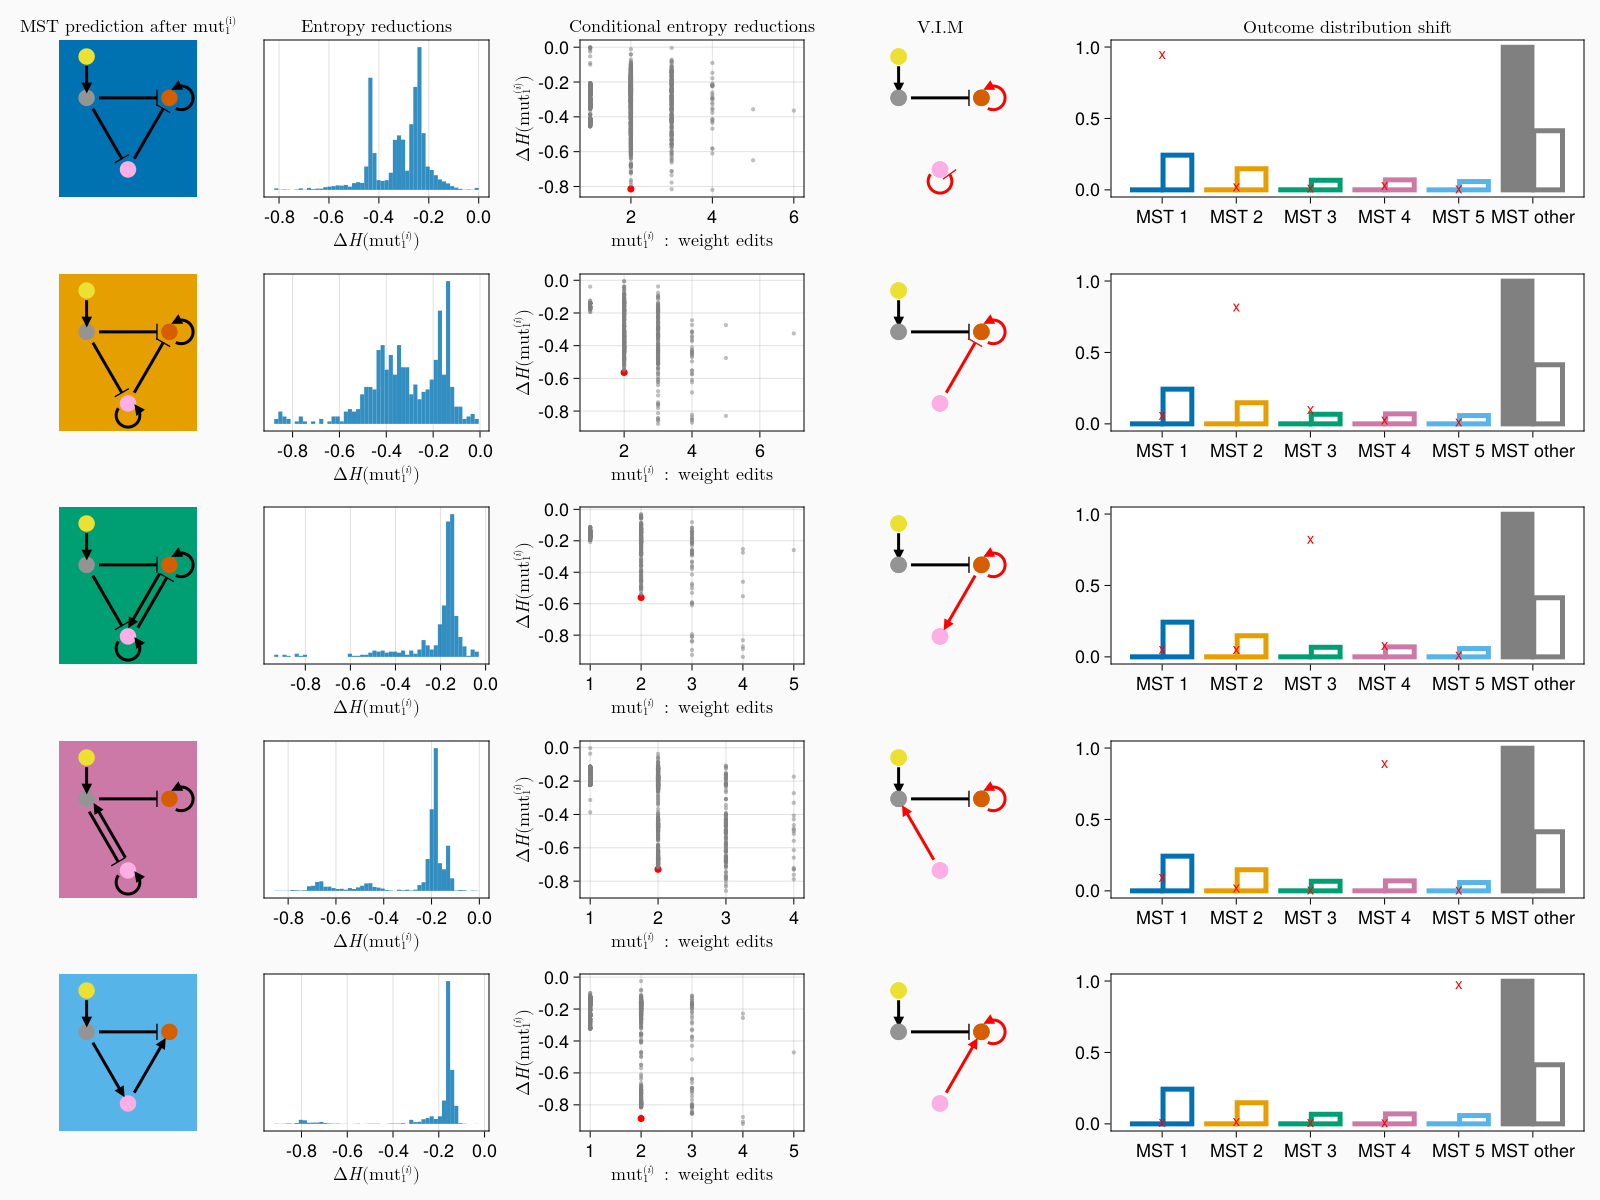

In [412]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1600, 1200),fontsize = 18.)

mut_n = 1

all_target_mutants = []
all_target_networks = []

ax_list = []

for n in 1:top_n

    if n == 1
        ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],1.), title = L"\text{MST prediction after \text{mut}^{(i)}_{1}}",aspect = DataAspect())

        ax_h = Axis(fig[n,2], title = L"\text{Entropy reductions}", xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], title = L"\text{Conditional entropy reductions}", xlabel = L"\text{mut}^{(i)}_{1} \text{ : weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4], title = L"\text{V.I.M}",backgroundcolor = RGBf(0.98, 0.98, 0.98),aspect = DataAspect())
    else
        ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],1.),aspect = DataAspect())

        ax_h = Axis(fig[n,2], xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], xlabel = L"\text{mut}^{(i)}_{1} \text{ : weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4],backgroundcolor = RGBf(0.98, 0.98, 0.98),aspect = DataAspect())
    end

    sample = filter(tr->tr.gt_label_predictions[mut_n+1] ∈ sorted_uep[n],trajectories_p)

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    sample_probabilities = map(tr->tr.gt_label_probabilities[mut_n+1,:],sample)

    # sample_top_edits_deltas = map(tr->map(mi->length(mi[:weight_id]),tr.mutant_info),sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample)

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas);

    max_ent_delta = minimum(sample_entropy_delta_select[findall(sample_top_edits_delta_select .== 2)])

    target_mutant_id = findall(sample_top_edits_delta_select .== 2) ∩ findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id[1]]

    target_prob = sample_probabilities[target_mutant_id[1]]

    push!(all_target_mutants,target_mutant)

    start_network = sample_start_networks[target_mutant_id[1]]
    resultant_network = sample_resultant_networks[target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))

    CairoMakie.hist!(ax_h,sample_entropy_delta_select ,bins = 50, normalization = :pdf)

    CairoMakie.scatter!(ax_s,sample_top_edits_delta_select,sample_entropy_delta_select ,markersize =  [i == target_mutant_id[1] ? 10. : 6. for i in 1:length(sample_entropy_delta_select)], color = [i == target_mutant_id[1] ? :red : (:grey,0.5) for i in 1:length(sample_entropy_delta_select)])

    draw_grn!(ax_geno,vertex_top_map[sorted_uep[n]],draw_config_18,node_colors1,fontsize,false,false)

    draw_grn_mutant!(ax_geno_m,start_network,resultant_network,draw_config_18,fs18_default,node_colors1,fontsize,false,false)

    hideydecorations!(ax_h)

    #####################

    if n ==1
        ax = Axis(fig[n,5:6], title = L"\text{Outcome distribution shift}")
    else
        ax = Axis(fig[n,5:6])
    end

    # pop = vim_trajectories[n]
    incl_count_all = []
    
    for k in 1:top_n
        top_to_check = vertex_top_map[sorted_uep[k]]
        # incl_count = sum(map(tr->tr.minimal_stripe_subgraphs[tr.H0] == top_to_check,pop))
        incl_count = rand()
        push!(incl_count_all,incl_count)
    end

    other = length(pop) - sum(incl_count_all)

    push!(incl_count_all,other)

    # non_conv = 5000 - sum(incl_count_all)

    # push!(incl_count_all,non_conv)

    p_dist = incl_count_all ./ sum(incl_count_all)

    # push!(all_prop,p_dist)

    p_dist_x = [i for i in 1:top_n +1]

    dodge_current = [1 for _ in 1:top_n+1]

    dodge_H0 = [2 for _ in 1:top_n+1]

    x = vcat(p_dist_x,p_dist_x)

    color = vcat([i == 6 ? (:grey,1.) : (color_scheme[i],1.) for i in p_dist_x],[:white for i in p_dist_x])

    stroke_color = [i == 6 ? (:grey,1.) : (color_scheme[i],1.) for i in x]

    dodge = vcat(dodge_current,dodge_H0)
    y = vcat(p_dist,null_H0_dist)

    CairoMakie.barplot!(ax,x,y,dodge = dodge,color = color, strokecolor = stroke_color, strokewidth = 5., gap = 0.2)

    CairoMakie.scatter!(ax,[1,2,3,4,5], target_prob, marker = 'x', color = :red, markersize = 15.)

    CairoMakie.hidedecorations!(ax,label = false,ticklabels = false,ticks = false,minorticks = false)

    axis_label = vcat(collect(string.(1:top_n)),["other"])
    
    ax.xticks = (1:top_n+1,["MST " * l for l in axis_label])

    push!(ax_list,ax)

end

linkyaxes!(ax_list...)

# save(plotsdirx("Experiment_1/FinalFigures_MSS","Fig4_VIM.png"),fig,pt_per_unit = 1)

fig

In [ ]:
for tr in trajectories_p
    if tr.other == nothing
        evaluate_epistasis_types!(tr,grn_parameters,DefaultGRNSolver(),fitness_function)
    end
end

In [ ]:
fig = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1600, 1200),fontsize = 18.)

mut_n = 1

all_target_mutants = []
all_target_networks = []

ax_list = []

for n in 1:top_n

    if n == 1
        ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],0.5), title = L"\text{MST prediction after \text{mut}^{(i)}_{1}}")

        ax_h = Axis(fig[n,2], title = L"\text{Entropy reductions}", xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], title = L"\text{Conditional entropy reductions}", xlabel = L"\text{mut}^{(i)}_{1} \text{ : weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4], title = L"\text{V.I.M}",backgroundcolor = RGBf(0.98, 0.98, 0.98))
    else
        ax_geno = Axis(fig[n,1],backgroundcolor = (color_scheme[n],0.5))

        ax_h = Axis(fig[n,2], xlabel = L"\Delta H(\text{mut}^{(i)}_{1})")
        ax_s = Axis(fig[n,3], xlabel = L"\text{mut}^{(i)}_{1} \text{ : weight edits}",ylabel = L"\Delta H(\text{mut}^{(i)}_{1})")

        ax_geno_m = Axis(fig[n,4],backgroundcolor = RGBf(0.98, 0.98, 0.98))
    end

    sample = filter(tr->tr.gt_label_predictions[mut_n+1] ∈ sorted_uep[n],trajectories_p)

    sample_entropy_deltas = map(tr->tr.gt_label_entropies[2:end] .- tr.gt_label_entropies[1:end-1],sample);
    sample_top_edits_deltas = map(tr->tr.weight_edits[2:end] .- tr.weight_edits[1:end-1],sample)

    sample_start_networks = map(tr->tr.geno_traj[mut_n],sample)
    sample_resultant_networks = map(tr->tr.geno_traj[mut_n+1],sample)

    incl_target = findall(sn->nothing_new_in_common(vertex_top_map[sorted_uep[n]],sn,sample_start_networks[1]),sample_resultant_networks)

    # sample_top_edits_deltas = map(tr->map(mi->length(mi[:weight_id]),tr.mutant_info),sample)

    sample_mutations = map(tr->tr.mutant_info[mut_n],sample[incl_target])

    sample_probabilities = map(tr->tr.gt_label_probabilities[mut_n+1,:],sample[incl_target])

    sample_top_edits_delta_select = map(x->x[mut_n],sample_top_edits_deltas[incl_target]);

    sample_entropy_delta_select = map(x->x[mut_n],sample_entropy_deltas[incl_target]);

    max_ent_delta = minimum(sample_entropy_delta_select)

    target_mutant_id = findall(sample_entropy_delta_select .== max_ent_delta)

    target_mutant = sample_mutations[target_mutant_id]

    target_prob = sample_probabilities[target_mutant_id[1]]

    push!(all_target_mutants,target_mutant)

    start_network = sample_start_networks[incl_target][target_mutant_id[1]]
    resultant_network = sample_resultant_networks[incl_target][target_mutant_id[1]]

    push!(all_target_networks,(start_network,resultant_network))

    CairoMakie.hist!(ax_h,sample_entropy_delta_select ,bins = 50, normalization = :pdf)

    CairoMakie.scatter!(ax_s,sample_top_edits_delta_select,sample_entropy_delta_select ,markersize =  [i == target_mutant_id[1] ? 10. : 6. for i in 1:length(sample_entropy_delta_select)], color = [i == target_mutant_id[1] ? :red : (:grey,0.5) for i in 1:length(sample_entropy_delta_select)])

    ax_s.xticks = (1:3,string.(1:3))

    top = Int.(reshape(vertex_top_map[sorted_uep[n]],(3,4)))

    draw_grn_layout!(ax_geno,top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors,false)

    # top = Int.(sign.(reshape(resultant_network,(3,4))))

    # orig_top = Int.(sign.(reshape(start_network,(3,4))))

    top = reshape(resultant_network,(3,4))

    orig_top = reshape(start_network,(3,4))

    draw_grn_layout_mutant!(ax_geno_m,top,orig_top,e_width,vertex_size,arrow_size,arrow_shift,sw,fixed_layout,selfedge_size,node_colors)

    hideydecorations!(ax_h)

    #####################

    if n ==1
        ax = Axis(fig[n,5:6], title = L"\text{Outcome distribution shift}")
    else
        ax = Axis(fig[n,5:6])
    end

    x = [i for i in 1:top_n +1]

    color = [:white for i in x]

    stroke_color = [i == 6 ? (:grey,0.5) : (color_scheme[i],0.5) for i in x]

    y = null_H0_dist

    CairoMakie.barplot!(ax,x,y,color = color, strokecolor = stroke_color, strokewidth = 5., gap = 0.2)

    CairoMakie.scatter!(ax,[1,2,3,4,5], target_prob, marker = 'x', color = :red, markersize = 15.)

    CairoMakie.hidedecorations!(ax,label = false,ticklabels = false,ticks = false,minorticks = false)

    axis_label = vcat(collect(string.(1:top_n)),["other"])
    
    ax.xticks = (1:top_n+1,["MST " * l for l in axis_label])

    push!(ax_list,ax)

end

linkyaxes!(ax_list...)

save(plotsdirx("Experiment_1/FinalFigures_MSS","Fig4_NI_VIM.png"),fig,pt_per_unit = 1)

fig

In [ ]:
# [0.0 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.011832370523359226 6.186784962141317 0.0 0.0]
# [0.0 -5.621450724457313 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 8.830210035714593 0.0 0.0]
# [0.0 0.0 -4.8195248537022 2.2607902395344572; 0.0 0.0 0.0 0.0; -0.21577059555519695 0.0 0.0 0.0]
# [2.6556076622814118 0.0 -1.6286143024847295 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 8.349277225287768 0.0 0.0]
# [-0.38415805370571476 0.0 0.0 1.2490335893436255; 0.0 0.0 0.0 0.0; -0.21577059555519695 7.9239930786560215 0.0 0.0]

test_networks = map(x->reshape(x[2],(3,4)), all_target_networks)

In [ ]:
test_networks_top = map(x->Int.(sign.(reshape(x[2],(3,4)))), all_target_networks)

In [ ]:
n1 = trajectories_p_d[2].geno_traj[6]
n2 = trajectories_p_d[2].geno_traj[7]

draw_config = fs18_default()

In [ ]:
fig = CairoMakie.Figure(resolution = (400,400), fontsize = fs)
ax = Axis(fig[1,1])

draw_grn_mutant!(ax,n1,n2,draw_config,fs18_default,node_colors,true)

fig

In [ ]:
fig = CairoMakie.Figure(resolution = (400,400), fontsize = fs)
ax = Axis(fig[1,1])

draw_grn!(ax,n1,draw_config,node_colors,true)

fig